In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import MeanSquareErrorLoss, LogCoshLoss
from mygrad.optimizers import SGD
from mygrad.preprocessors import MinMaxScaler, StandardScaler, IdentityScaler
from mygrad.trainers import Trainer as RegressionTrainer, ProgressBar
from mygrad.dataloaders import NumpyRegressionDataloader

# Steps Small

In [8]:
train_df = pd.read_csv("../mio1/regression/steps-small-training.csv")
test_df = pd.read_csv("../mio1/regression/steps-small-test.csv")

In [9]:
X_train = train_df["x"].values
y_train = train_df["y"].values

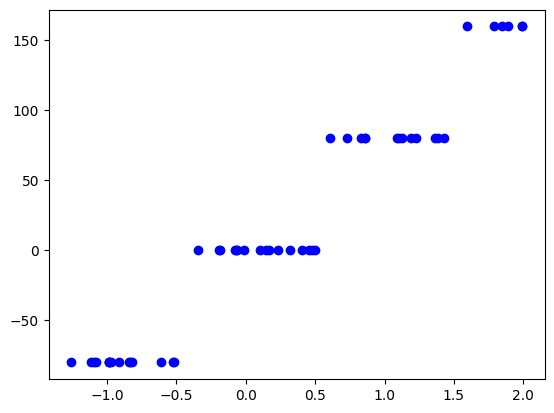

In [10]:
p = np.argsort(X_train)
plt.plot(X_train[p], y_train[p], "bo")

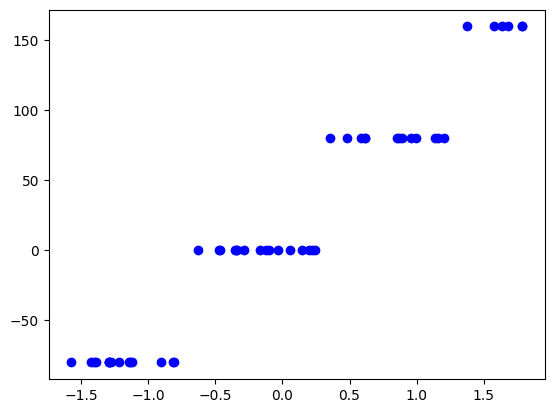

In [11]:
input_normalizer = StandardScaler()
output_normalizer = IdentityScaler()

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

X_train_scaled = input_normalizer.fit_transform(X_train)
y_train_scaled = output_normalizer.fit_transform(y_train)

plt.plot(X_train_scaled[p, :], y_train_scaled[p, :], "bo")

In [12]:
len(X_train_scaled)

50

In [19]:
model = mc.Sequential(
    mc.Linear(1, 10, init="xavier"),
    mc.Tanh(),
    mc.Linear(10, 10, init="xavier"),
    mc.Tanh(),
    mc.Linear(10, 1, init="uniform"),
)
optimizer = SGD(model.parameters(), learning_rate=6e-4, momentum=0.8, dampening=0.8, nesterov=True)
loss = MeanSquareErrorLoss()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=10, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses = trainer.train(3_000)["loss"]



Training epochs:   0%|          | 0/3000 [00:00<?, ?it/s]

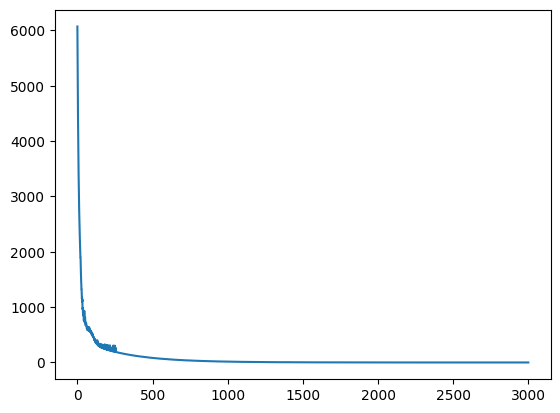

In [20]:
plt.plot(train_losses)
plt.show()

In [21]:
optimizer = SGD(model.parameters(), learning_rate=3e-3)
loss = MeanSquareErrorLoss()
train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train_scaled, batch_size=50, shuffle=True)
trainer = RegressionTrainer(model, optimizer, loss, train_dataloader, plugins=[ProgressBar()])
train_losses = trainer.train(100_000)["loss"]

print(train_losses[-20:].max())

Training epochs:   0%|          | 0/100000 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'max'

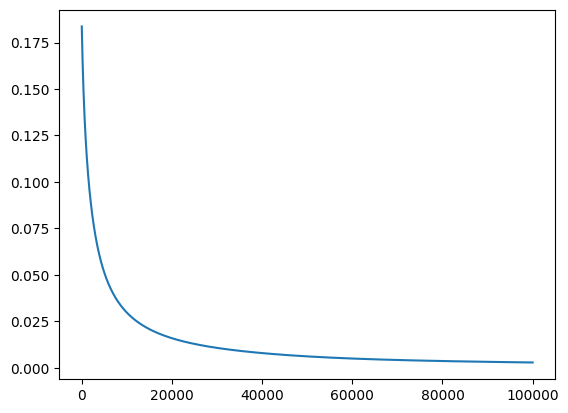

In [25]:
plt.plot(train_losses)
plt.show()

/tmp/ipykernel_16376/1547620780.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mse = float(mf.mse(output_normalizer.reverse(y_pred), y_train))


Text(0.5, 1.0, 'Wizualizacja predykcji na zbiorze treningowym, MSE: 0.0028')

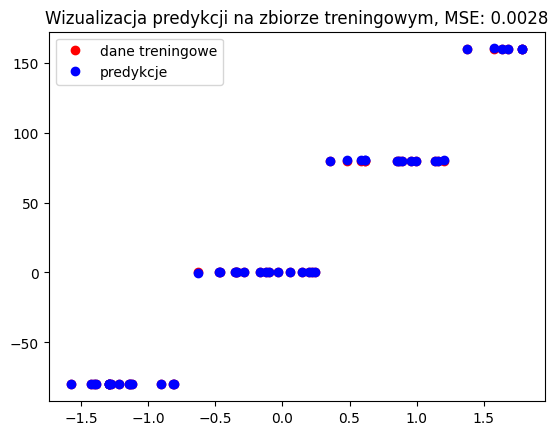

In [36]:
y_pred = model.forward(X_train_scaled)
mse = float(mf.mse(output_normalizer.reverse(y_pred), y_train))
plt.plot(X_train_scaled, y_train_scaled, "ro", label="dane treningowe")
plt.plot(X_train_scaled, y_pred, "bo", label="predykcje")
plt.legend()
plt.title(f"Wizualizacja predykcji na zbiorze treningowym, MSE: {mse:.4f}")


/tmp/ipykernel_16376/1562957342.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mse = float(mf.mse(y_pred, y_test))


Text(0.5, 1.0, 'Wizualizacja predykcji na zbiorze testowym, MSE: 92.5856')

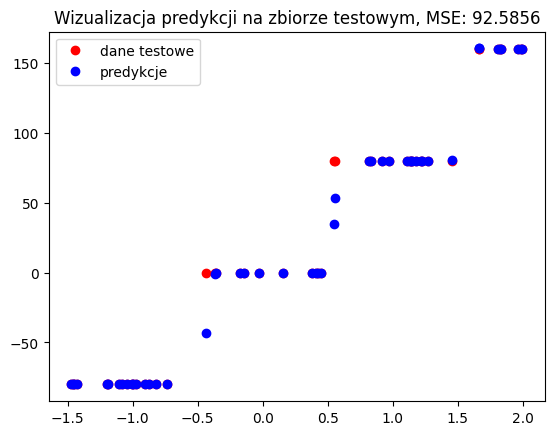

In [37]:
X_test = test_df["x"].values.reshape(-1, 1)
y_test = test_df["y"].values.reshape(-1, 1)

X_test_scaled = input_normalizer.transform(X_test)

y_pred_scaled = model.forward(X_test_scaled)
y_pred = output_normalizer.reverse(y_pred_scaled)

plt.plot(X_test, y_test, "ro", label="dane testowe")
plt.plot(X_test, y_pred, "bo", label="predykcje")

mse = float(mf.mse(y_pred, y_test))

plt.legend()
plt.title(f"Wizualizacja predykcji na zbiorze testowym, MSE: {mse:.4f}")


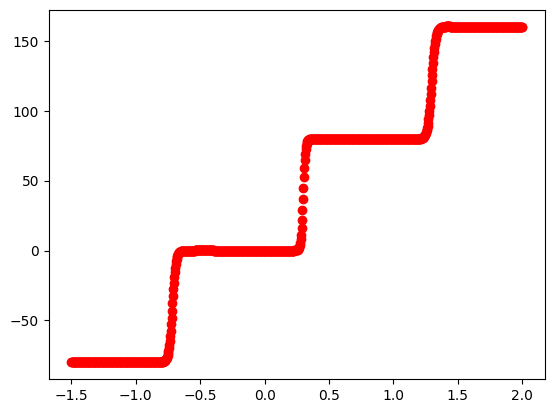

In [17]:
X_seq = np.linspace(-1.5, 2, 1000).reshape(-1, 1)
y_seq = model.forward(X_seq)
plt.plot(X_seq, output_normalizer.reverse(y_seq), "ro")

Text(0.5, 1.0, 'Wizualizacja różnicy między danymi treningowymi i testowymi')

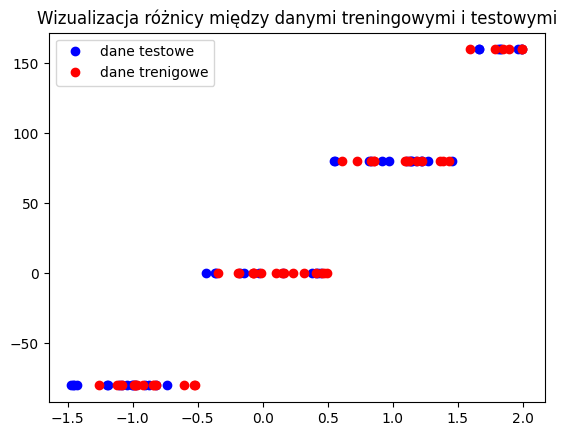

In [43]:
plt.plot(X_test, y_test, "bo", label="dane testowe")
plt.plot(X_train, y_train, "ro", label="dane trenigowe")
plt.legend()
plt.title("Wizualizacja różnicy między danymi treningowymi i testowymi")